<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/GravityResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install "git+https://github.com/Karasiari/graphmcf.git"

  Cloning https://github.com/Karasiari/graphmcf.git to /tmp/pip-req-build-pp9wccrn
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/graphmcf.git /tmp/pip-req-build-pp9wccrn
  Resolved https://github.com/Karasiari/graphmcf.git to commit dd6c92c250f30941942559be6340885a645a2958
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for graphmcf: filename=graphmcf-0.1.0-py3-none-any.whl size=36243 sha256=603d982a39f6aaf7a8ea21236bb4f21ec9e5cb6cc5ca0cddfb17d89fc9c53709
  Stored in directory: /tmp/pip-ephem-wheel-cache-_rr_nppt/wheels/e2/0b/c2/f959f38e6d22c15057366b9e17b9295eb9dfc85fd11eff7962
Successfully built graphmcf


In [2]:
import pandas as pd
import numpy as np
import os # Выберите, откуда тяните папку
from google.colab import files

BITRATE_DENOMINATOR = 100

# По папке формируем словарь графов со структурой -
#                                                {'название графа (как в папке)':
#                                                       {'adj_matrix': матрица смежности взвешенного графа - веса capacity,
#                                                        'traffic_matrix': матрица корреспонденций,
#                                                        'nodes_params': {'degrees': список степеней вершин,
#                                                                         'source_demands': список суммарного входящего траффика,
#                                                                         'target_demands': список суммарного исходящего траффика,
#                                                                         'sum_demands': список усредненного траффика (source + target) / 2
#                                                                        }
#                                                       }
#                                                }

def csv_to_graph(path, demands_path, capacity_path):
  Df = pd.read_csv(path, header=None, names = ['id', 'source', 'target', 'length'])
  Traffic = pd.read_csv(demands_path, header=None, names = ['id', 'source', 'target', 'bitrate'])
  Capacity = pd.read_csv(capacity_path, header=None, names = ['name', 'value'])
  df = Df.iloc[1:].copy()
  traffic = Traffic.iloc[1:].copy()
  capacity = Capacity.iloc[1:].copy()
  df['source'] = df['source'].astype(int)
  df['target'] = df['target'].astype(int)
  #df['length'] = df['length'].astype(float)
  traffic['source'] = traffic['source'].astype(int)
  traffic['target'] = traffic['target'].astype(int)
  traffic['bitrate'] = traffic['bitrate'].astype(int) // BITRATE_DENOMINATOR
  traffic_grouped = traffic.groupby(['source', 'target']).sum().reset_index()
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])

  sources = df['source'].tolist()
  targets = df['target'].tolist()
  lengths = df['length'].tolist()

  unique_vertices = set()
  for source, target in zip(sources, targets):
    unique_vertices.add(source)
    unique_vertices.add(target)
  vertex_mapping = {old: new for new, old in enumerate(unique_vertices)}
  num_vertices = len(unique_vertices)

  adj_matrix = np.zeros((num_vertices, num_vertices))
  traffic_matrix = np.zeros((num_vertices, num_vertices))

  for source, target, length in zip(sources, targets, lengths):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    #adj_matrix[new_source, new_target] = length
    #adj_matrix[new_target, new_source] = length
    adj_matrix[new_source, new_target] = capacity_value
    adj_matrix[new_target, new_source] = capacity_value

  traffic_grouped['source'] = traffic_grouped['source'].map(vertex_mapping)
  traffic_grouped['target'] = traffic_grouped['target'].map(vertex_mapping)
  for _, row in traffic_grouped.iterrows():
    traffic_matrix[row['source'], row['target']] = row['bitrate']

  nodes_params = {}

  degrees = list(np.count_nonzero(adj_matrix, axis=1).astype(np.float64))
  nodes_params['degrees'] = degrees

  source_demands = list(np.sum(traffic_matrix, axis=1))
  nodes_params['source_demands'] = source_demands

  target_demands = list(np.sum(traffic_matrix, axis=0))
  nodes_params['target_demands'] = target_demands

  sum_demands = [(i + j)/2 for (i,j) in zip(source_demands, target_demands)]
  nodes_params['sum_demands'] = sum_demands

  return (adj_matrix, traffic_matrix, nodes_params)

def get_graphs(base_path, specified_graphs, specified):
  Graphs = {}
  csv_tables = []
  for folder_name in os.listdir(base_path):
    if folder_name in specified_graphs or not specified:
      folder_path = os.path.join(base_path, folder_name)
      csv_path = os.path.join(folder_path, 'links.csv')
      csv_path_demands = os.path.join(folder_path, 'demands.csv')
      csv_path_capacity = os.path.join(folder_path, 'params.csv')
      csv_tables.append(folder_name)

      (adj_matrix, traffic_matrix, nodes_params) = csv_to_graph(csv_path, csv_path_demands, csv_path_capacity)
      Graphs[folder_name] = {'adj_matrix': adj_matrix, 'traffic_matrix': traffic_matrix, 'nodes_params': nodes_params}

  return Graphs

path_to_folder = '/content/drive/MyDrive/Кола' # Свой путь

In [3]:
import numpy as np

import cvxpy as cp
import networkx as nx

from dataclasses import dataclass
from typing import Optional

@dataclass(frozen=True)
class Solution:
    problem: cp.Problem
    flow: np.ndarray
    add_bandwidth: Optional[np.ndarray] = None
    gamma: Optional[float] = None
    traffic_mat: Optional[float] = None

    def to_vector(self) -> np.ndarray:
        sol_parts = [self.flow.T.flatten()]
        if self.add_bandwidth is not None:
            sol_parts.append(self.add_bandwidth)
        if self.gamma is not None:
            sol_parts.append(self.gamma)
        return np.hstack(sol_parts)


def vector_to_solution(graph: nx.DiGraph, vec: np.ndarray, problem_type: str):
    m, n = graph.number_of_edges(), graph.number_of_nodes()
    flow = vec[: m * n].reshape(n, m).T
    add_bandwidth = None
    gamma = None
    if problem_type in ["opt_network_min_cost_concurrent_flow", "opt_network_max_concurrent_flow"]:
        add_bandwidth = vec[m * n : m * n + m]
    if problem_type in ["max_concurrent_flow", "opt_network_max_concurrent_flow"]:
        gamma = vec[-1]
    return Solution(problem=None, flow=flow, add_bandwidth=add_bandwidth, gamma=gamma)

# Вспомогательные

def get_incidence_matrix(graph: nx.DiGraph) -> np.ndarray:
    """
    Construct incidence matrix
    :param graph: nx.DiGraph,: graph with attribute cost on edges
    :return:
        incidence_matrix: ndarray of shape (num_nodes, num_edges), incidence matrix
    """
    incidence_matrix = nx.incidence_matrix(graph, edgelist=graph.edges, oriented=True)
    incidence_matrix = incidence_matrix.toarray()
    return incidence_matrix

def get_weights(graph: nx.DiGraph) -> np.ndarray:
    """
    Extract edge weights
    :param graph: nx.DiGraph, graph with weights on edges
    :param key: str, name of attribute to obtain weights
    :return:
        weights: ndarray of shape (num_nodes), all edge weights in graph
    """
    edges_with_weights = [(edge, data['weight']) for edge, data in graph.edges.items()]
    edges_with_weights_dict = {key: value for key, value in edges_with_weights}
    return np.array(list(edges_with_weights_dict.values()), dtype=np.float64)

def get_var_value(var: Optional[cp.Variable]) -> Optional[float | np.ndarray]:
    """
    Get cvxpy.Variable value if not None
    :param var: cvxpy.Variable, variable to extract value
    :return:
        value: var.value if var is not None, else None
    """
    return var.value if var is not None else None


# Решение

def solve_throughput(graph: nx.Graph, traffic_lapl: np.ndarray, **solver_kwargs) -> Solution:
    graph = nx.DiGraph(graph)
    incidence_mat = get_incidence_matrix(graph)
    bandwidth = get_weights(graph)

    flow = cp.Variable((len(graph.edges), traffic_lapl.shape[0]))
    gamma = cp.Variable()
    prob = cp.Problem(
        cp.Maximize(gamma),
        [cp.sum(flow, axis=1) <= bandwidth, incidence_mat @ flow == -gamma * traffic_lapl.T, flow >= 0, gamma >= 0],
    )
    prob.solve(**solver_kwargs)

    if prob.status != "optimal":
        gamma = None

    return Solution(problem=prob, flow=get_var_value(flow), gamma=get_var_value(gamma))

In [21]:
small_graphs_for_test_names = ['2024_north']
small_graphs_for_test = get_graphs(path_to_folder, small_graphs_for_test_names, True)

/tmp/ipython-input-3803984810.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])
/tmp/ipython-input-3803984810.py:34: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])


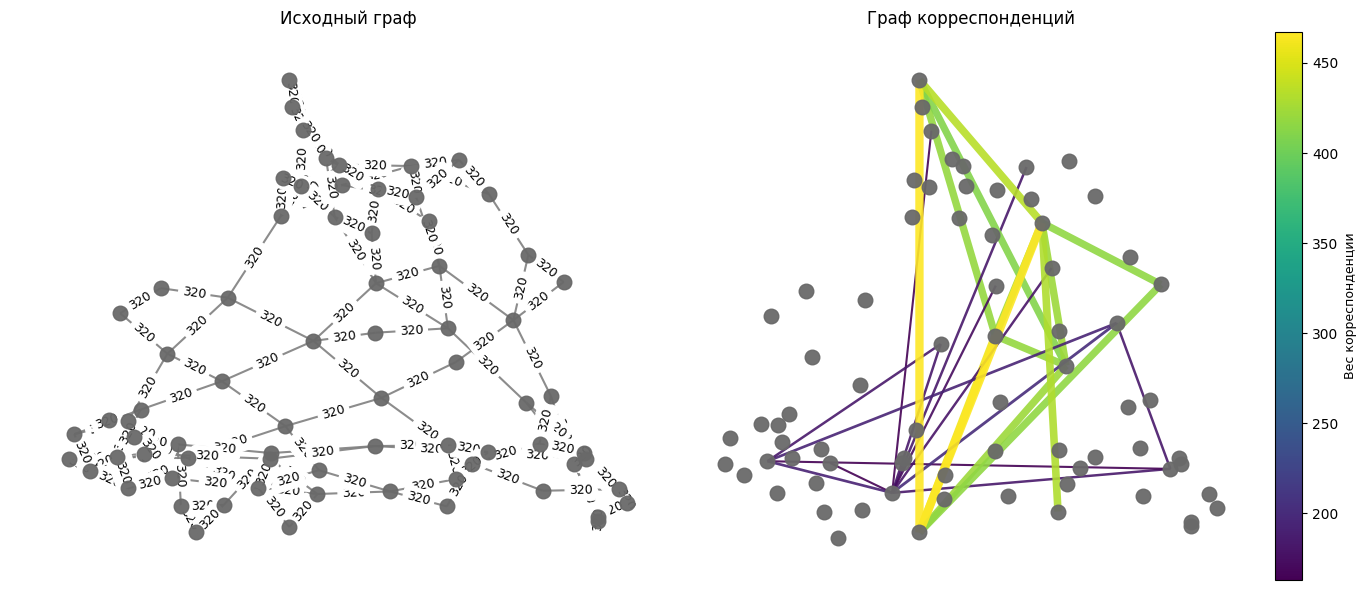

In [37]:
import numpy as np
from graphmcf.core import GraphMCF
from graphmcf.demands import GravitationalGenerator

for name, graph in small_graphs_for_test.items():
  graph_gravity = GraphMCF(graph['adj_matrix'])
  gen = GravitationalGenerator(beta=0.8, intensity=8000, centrality='pagerank', edge_perc=0.01)
  res = gen.generate(graph_gravity)
  graph_gravity.visualise_with_demands()

In [38]:
from graphmcf.data import compute_laplacian_matrix

betas_batch = [0.8, 0.6, 0.4, 0.2]
iter_stats = 20
output_for_stats = []
for i in range(iter_stats):
  for name, graph in small_graphs_for_test.items():
    betas_gamma = []
    for beta in betas_batch:
      graph_gravity = GraphMCF(graph['adj_matrix'])
      gen = GravitationalGenerator(beta=beta, intensity=8000, centrality='pagerank', edge_perc=0.01)
      res = gen.generate(graph_gravity)
      demands_laplacian = compute_laplacian_matrix(graph_gravity.demands_graph)
      sol = solve_throughput(graph_gravity.graph, demands_laplacian)
      gamma = sol.gamma
      betas_gamma.append(f"beta={beta}: {gamma}")
      output_for_stats.append((beta, gamma))
    gamma_sequence = " ".join(betas_gamma)
    print(f"\n\nРешение MCF на итоге:\nЗначения gamma: {gamma_sequence}\n\n")



Решение MCF на итоге:
Значения gamma: beta=0.8: 0.24681835709791905 beta=0.6: 0.30374940607538625 beta=0.4: 0.37944664027810293 beta=0.2: 0.3595505612622351




Решение MCF на итоге:
Значения gamma: beta=0.8: 0.2418745271439704 beta=0.6: 0.29357798135791496 beta=0.4: 0.3736862592180545 beta=0.2: 0.3584095571401948




Решение MCF на итоге:
Значения gamma: beta=0.8: 0.2437166793372363 beta=0.6: 0.3069544364201547 beta=0.4: 0.3836930439938923 beta=0.2: 0.35847647401318317




Решение MCF на итоге:
Значения gamma: beta=0.8: 0.23651145601178686 beta=0.6: 0.2987861807743984 beta=0.4: 0.3747072586020455 beta=0.2: 0.3587443939275806




Решение MCF на итоге:
Значения gamma: beta=0.8: 0.2416918424262262 beta=0.6: 0.3036053125244349 beta=0.4: 0.37551339585866406 beta=0.2: 0.3586773764261148




Решение MCF на итоге:
Значения gamma: beta=0.8: 0.24187452757492583 beta=0.6: 0.29962546683548996 beta=0.4: 0.3814822164706179 beta=0.2: 0.34588362411234325




Решение MCF на итоге:
Значения gamma: be

In [40]:
from scipy.stats import pearsonr

x, y = [], []
for i, j in output_for_stats:
  x.append(i)
  y.append(float(j))

corr_coef, p_value = pearsonr(x, y)
alpha = 0.05
is_significant = p_value < alpha

print(f"Коэффициент корреляции: {corr_coef:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Результат значим при alpha={alpha}: {is_significant}")

Коэффициент корреляции: -0.8845
P-value: 0.0000
Результат значим при alpha=0.05: True
